In [3]:
import numpy as np
import pandas as pd
import h5py
np.random.seed(0)
import random
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D, BatchNormalization
from keras import backend as K
from keras.utils import to_categorical
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


Reading Data

In [4]:
train = pd.read_csv('/content/drive/MyDrive/train.csv')
test = pd.read_csv('/content/drive/MyDrive/test.csv')
X_train = train.drop(labels = ['label'], axis =1)
y_train = train['label']
X_test = test
print(X_train.shape, X_test.shape)

(42000, 784) (28000, 784)


In [5]:
X_train_plot = X_train.values.reshape(-1,28,28)

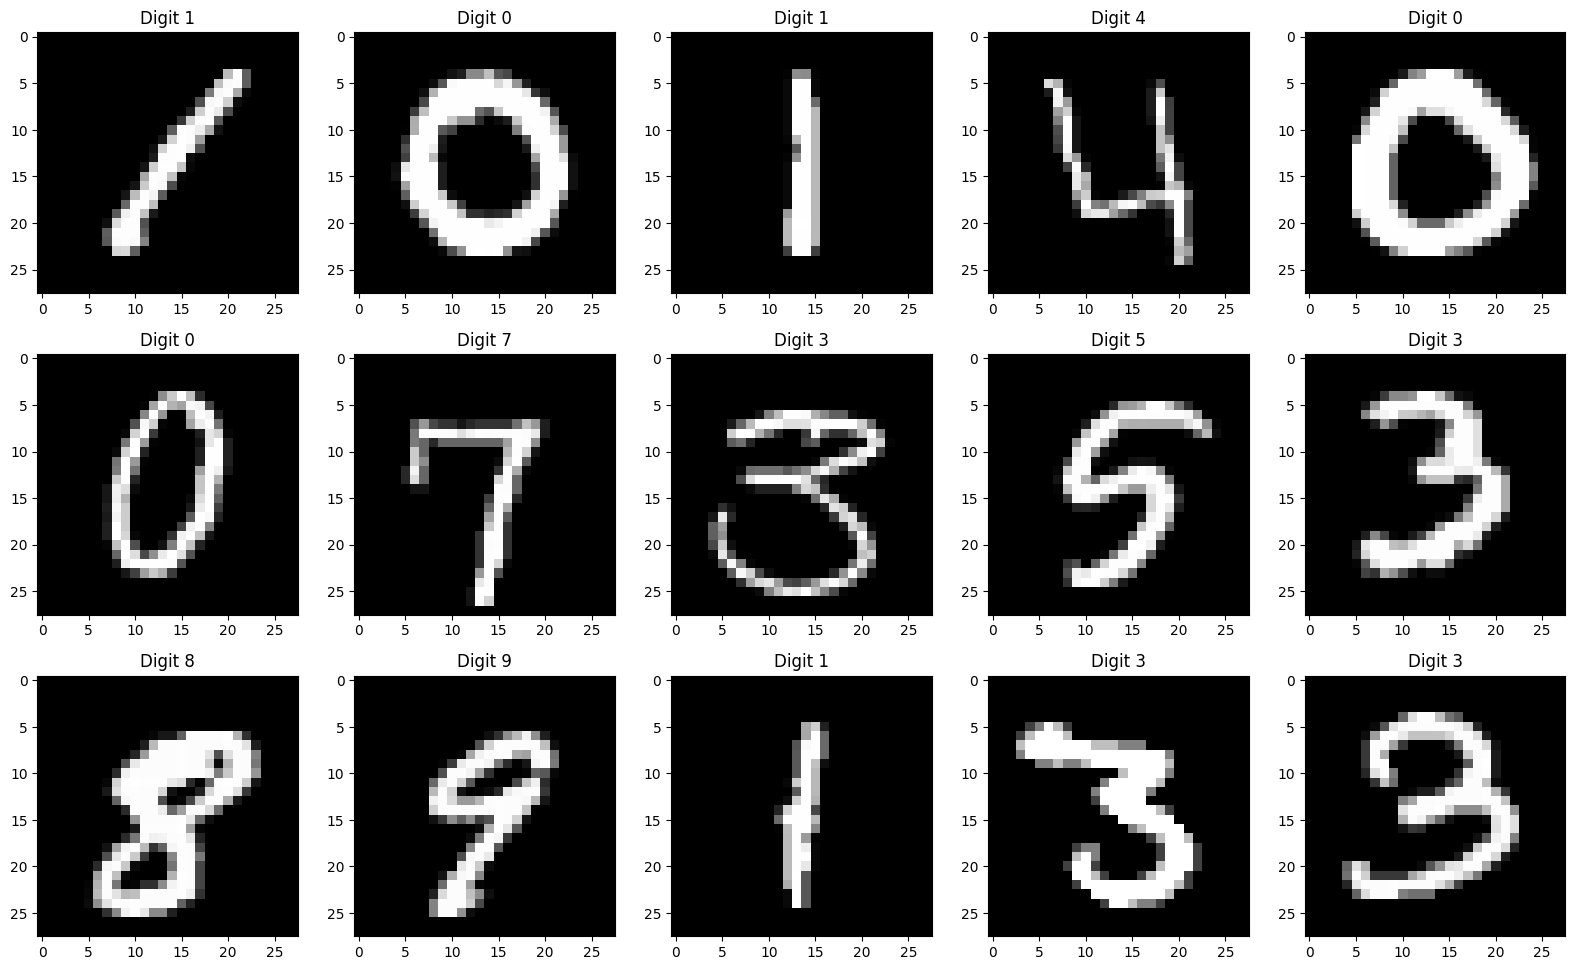

In [6]:
def show_example_digits(mono = 'gray'):
    fig = plt.figure(figsize = (16,16))
    for idx in range(15):
        plt.subplot(5,5,idx+1)
        plt.imshow(X_train_plot[idx], cmap = mono)
        plt.title("Digit {}".format(y_train[idx]))
    plt.tight_layout()

show_example_digits()

In [7]:
# Function return digit in grayscale
def plot_digit(digit, dem=28, font_size = 12):
    max_ax = font_size*dem

    fig = plt.figure(figsize=(13,13))
    plt.xlim([0,max_ax])
    plt.ylim([0, max_ax])
    plt.axis('off')
    black = '#000000'

    for idx in range (dem):
        for jdx in range(dem):
            t = plt.text(idx*font_size, max_ax-jdx*font_size, digit[jdx][idx], fontsize = font_size, color = black)
            c = digit[jdx][idx]/255
            t.set_bbox(dict(facecolor=(c,c,c), alpha = 0.5, edgecolor = 'black'))

    plt.show()

3


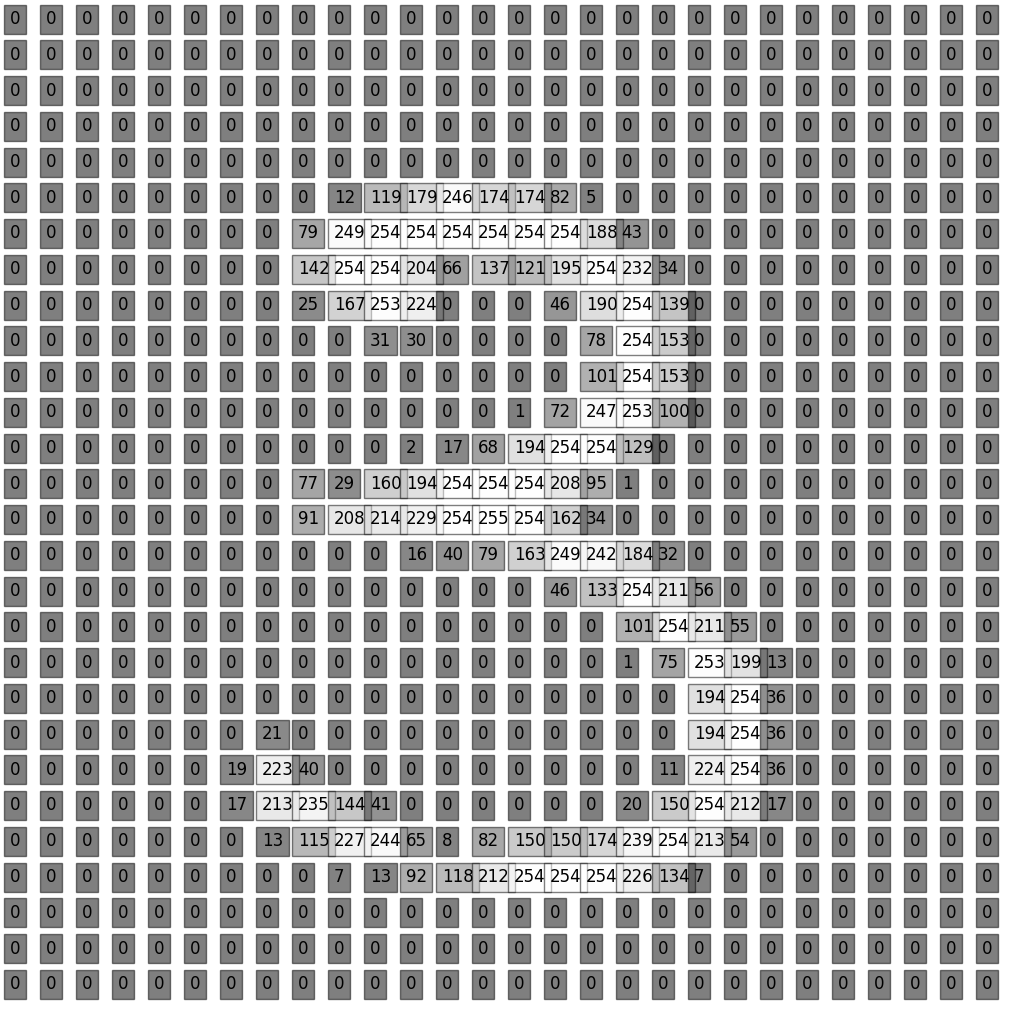

In [8]:
rand_number = random.randint(0, len(y_train))
print(y_train[rand_number])
plot_digit(X_train_plot[rand_number])

<BarContainer object of 10 artists>

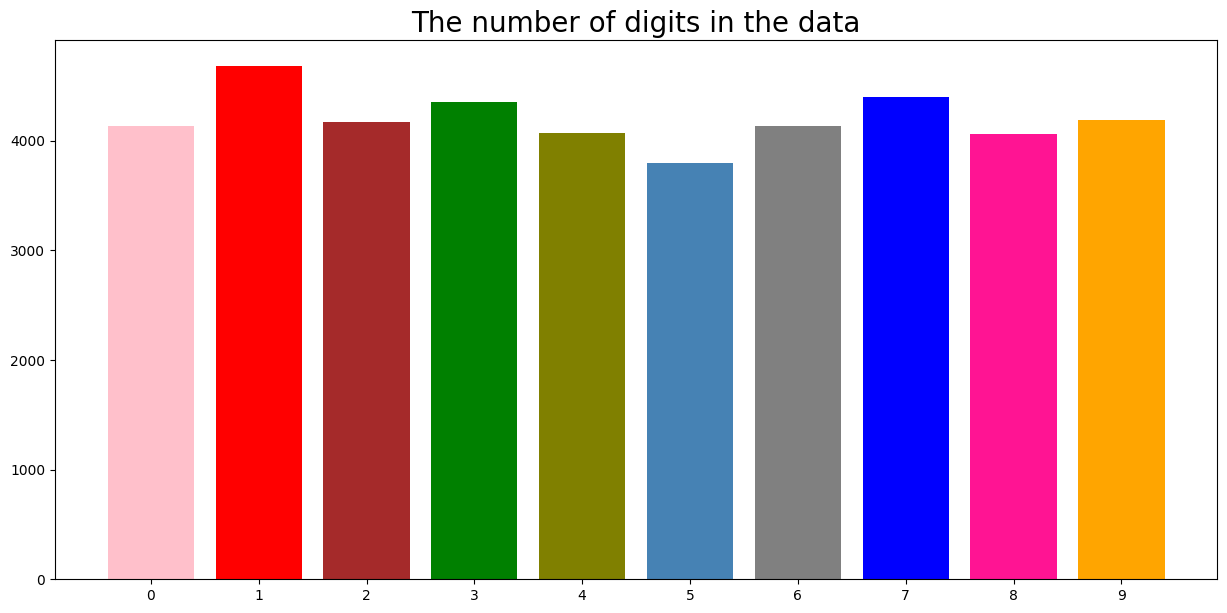

In [9]:
digit_range = np.arange(10)
val = y_train.value_counts().index
cnt = y_train.value_counts().values
mycolors =['red', 'blue', 'green', 'orange', 'brown', 'grey','pink','olive','deeppink','steelblue']

plt.figure(figsize=(15,7))
plt.title("The number of digits in the data", fontsize = 20)

plt.xticks(range(10))
plt.bar(val,cnt,color=mycolors)

In [10]:
# data Preparing
img_rows, img_cols = 28,28
num_pixels = X_train.shape[1]
input_shape = (img_rows, img_cols)

In [11]:
# Data Noramlization [0,1]
X_train/=255
X_test/=255

# one-hot encoding for target column
y_train = to_categorical(y_train)

num_classes = y_train.shape[1]

# Number of objects, vector size (28*28)
print(X_train.shape, X_test.shape)

(42000, 784) (28000, 784)


In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size = 0.1, random_state=2, stratify = y_train)

In [13]:
# # from keras import backend as K
# def f1(y_true, y_pred):
#     def recall(y_true, y_pred):
#         true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0,1)))
#         possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#         recall = true_positives/ (possible_positives +K.epsilon())
#         return recall
#     def precision(y_true, y_pred):
#         true_positives = k.sum(K.round(K.clip(y_true*y_pred, 0, 1)))
#         predicted_positives = K.sum(K.round(K.clip(y_pred,0, 1)))
#         precision = true_positives/ (predicted_positives +K.epsilon())
#         return precision

#     precision = precision(y_true, y_pred)
#     recall = recall(y_true, y_pred)
#     return 2*((precision*recall)/ precision + recall+K.epsilon())




# from keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


In [14]:
# function to draw learning curve
def draw_learning_curve(history, keys=['f1', 'loss']):
    plt.figure(figsize = (20,8))
    for i, key in enumerate(keys):
        plt.subplot(1,2,i+1)
        sns.lineplot(x=history.epoch, y=history.history[key])
        sns.lineplot(x=history.epoch, y=history.history['val_'+key])
        plt.title('Learning Curve')
        plt.ylabel(key.title())
        plt.xlabel('Epoch')
        plt.legend(['train', 'test'], loc='best')
    plt.show()

In [15]:
def callbacks(name):
    return [
        EarlyStopping(monitor = 'loss', patience = 6),
        ReduceLROnPlateau(monitor = 'loss', patience = 3),
        ModelCheckpoint(f'/content/drive/MyDrive/Mobile data/{name}.hdf5', save_best_only=True) # saving the best model
    ]

In [16]:
def get_mlp():
    return keras.Sequential([
        # input layer is automatically generated by Keras

        # hidden layer
        keras.layers.Dense(512, input_dim=num_pixels, activation='relu'),

        # output layer
        keras.layers.Dense(num_classes, activation='softmax')
    ])


In [17]:
model = get_mlp()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [18]:
learning_history = model.fit(X_train, y_train,
          batch_size = 1024, epochs = 40, verbose = 2, callbacks = callbacks('simple_mlp'),
          validation_data=(X_val, y_val));

Epoch 1/40
37/37 - 7s - loss: 0.6829 - f1: 0.7217 - val_loss: 0.3238 - val_f1: 0.9003 - lr: 0.0010 - 7s/epoch - 194ms/step
Epoch 2/40
37/37 - 0s - loss: 0.2701 - f1: 0.9234 - val_loss: 0.2498 - val_f1: 0.9290 - lr: 0.0010 - 306ms/epoch - 8ms/step
Epoch 3/40
37/37 - 0s - loss: 0.2109 - f1: 0.9418 - val_loss: 0.2072 - val_f1: 0.9382 - lr: 0.0010 - 269ms/epoch - 7ms/step
Epoch 4/40
37/37 - 0s - loss: 0.1737 - f1: 0.9531 - val_loss: 0.1782 - val_f1: 0.9494 - lr: 0.0010 - 283ms/epoch - 8ms/step
Epoch 5/40
37/37 - 0s - loss: 0.1471 - f1: 0.9599 - val_loss: 0.1549 - val_f1: 0.9537 - lr: 0.0010 - 281ms/epoch - 8ms/step
Epoch 6/40
37/37 - 0s - loss: 0.1272 - f1: 0.9659 - val_loss: 0.1451 - val_f1: 0.9530 - lr: 0.0010 - 296ms/epoch - 8ms/step
Epoch 7/40
37/37 - 0s - loss: 0.1101 - f1: 0.9703 - val_loss: 0.1324 - val_f1: 0.9596 - lr: 0.0010 - 265ms/epoch - 7ms/step
Epoch 8/40
37/37 - 0s - loss: 0.0956 - f1: 0.9750 - val_loss: 0.1223 - val_f1: 0.9610 - lr: 0.0010 - 259ms/epoch - 7ms/step
Epoch 9/4

In [19]:
score = model.evaluate(X_val, y_val, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test score: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 8.598458021879196%
Test score: 97.60475158691406%
MLP Error: 2.40%


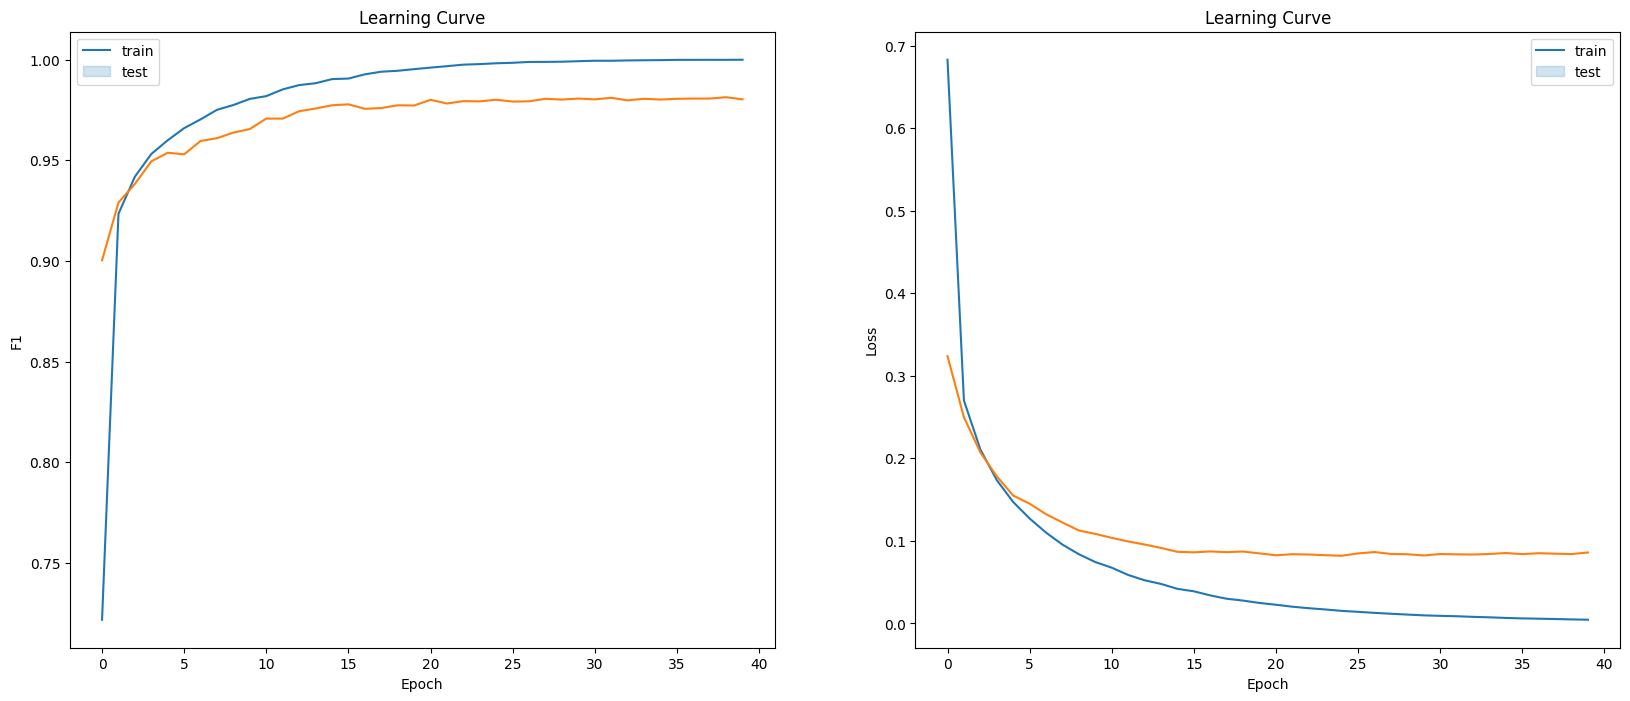

In [20]:
draw_learning_curve(learning_history)

In [21]:
def get_mlpv2():

    return Sequential([
        Dense(512, input_dim=num_pixels, activation='relu'),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

In [22]:
model = get_mlpv2()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 567,434
Trainable params: 567,434
Non-tr

In [23]:
learning_history = model.fit(X_train, y_train,
          batch_size = 1024, epochs = 40, verbose = 2, callbacks = callbacks('mlp_reg'),
          validation_data=(X_val, y_val));

Epoch 1/40
37/37 - 3s - loss: 0.7635 - f1: 0.6901 - val_loss: 0.2867 - val_f1: 0.9048 - lr: 0.0010 - 3s/epoch - 69ms/step
Epoch 2/40
37/37 - 0s - loss: 0.2537 - f1: 0.9245 - val_loss: 0.1765 - val_f1: 0.9443 - lr: 0.0010 - 332ms/epoch - 9ms/step
Epoch 3/40
37/37 - 0s - loss: 0.1802 - f1: 0.9459 - val_loss: 0.1361 - val_f1: 0.9526 - lr: 0.0010 - 364ms/epoch - 10ms/step
Epoch 4/40
37/37 - 0s - loss: 0.1422 - f1: 0.9584 - val_loss: 0.1110 - val_f1: 0.9641 - lr: 0.0010 - 375ms/epoch - 10ms/step
Epoch 5/40
37/37 - 0s - loss: 0.1144 - f1: 0.9648 - val_loss: 0.0969 - val_f1: 0.9698 - lr: 0.0010 - 332ms/epoch - 9ms/step
Epoch 6/40
37/37 - 0s - loss: 0.0956 - f1: 0.9712 - val_loss: 0.0899 - val_f1: 0.9713 - lr: 0.0010 - 319ms/epoch - 9ms/step
Epoch 7/40
37/37 - 0s - loss: 0.0804 - f1: 0.9756 - val_loss: 0.0816 - val_f1: 0.9737 - lr: 0.0010 - 343ms/epoch - 9ms/step
Epoch 8/40
37/37 - 0s - loss: 0.0647 - f1: 0.9806 - val_loss: 0.0797 - val_f1: 0.9717 - lr: 0.0010 - 479ms/epoch - 13ms/step
Epoch 9

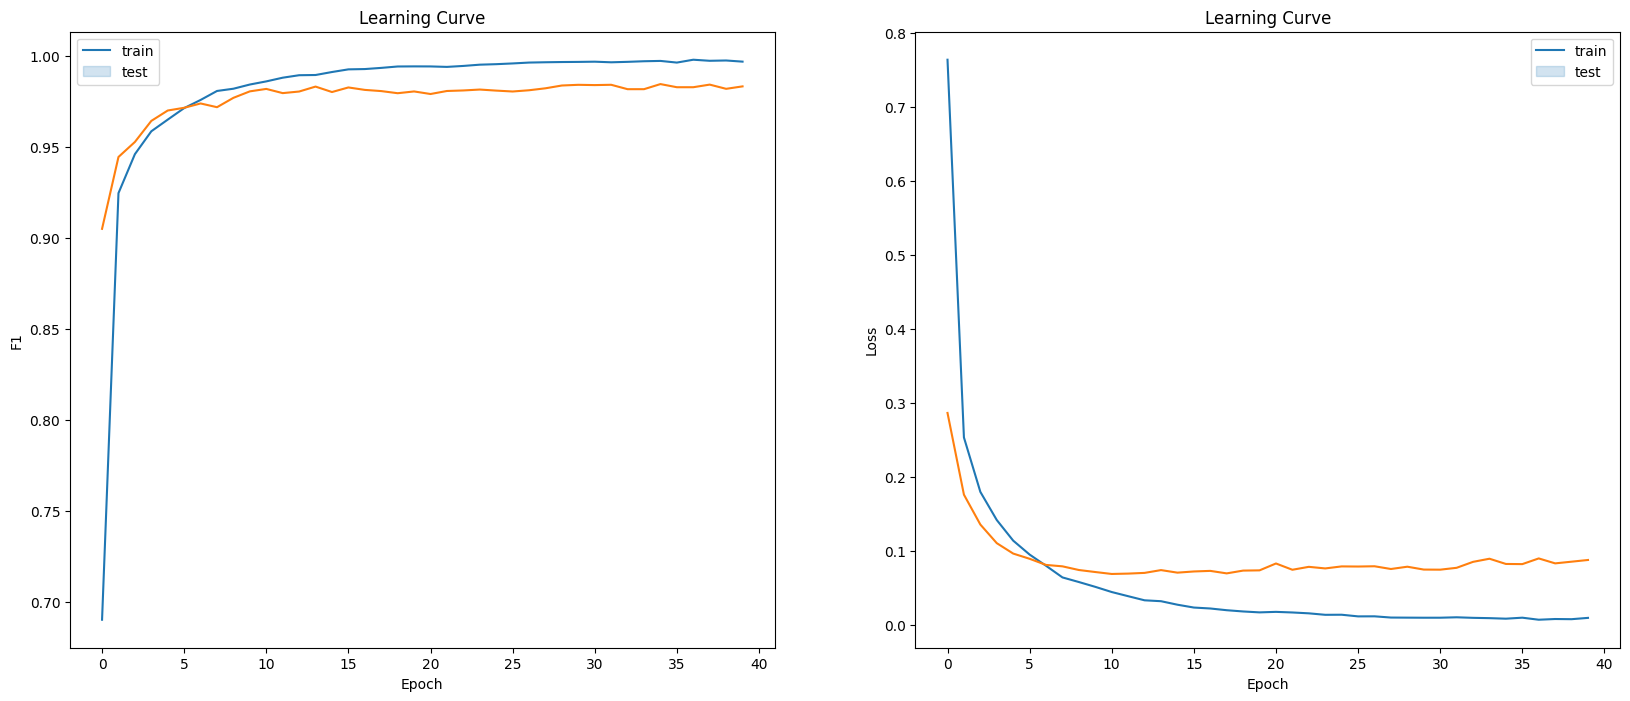

In [24]:
draw_learning_curve(learning_history)

In [25]:
score = model.evaluate(X_val, y_val, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test score: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 8.827663958072662%
Test score: 97.95199036598206%
MLP Error: 2.05%


In [26]:
X_train.shape

(37800, 784)

In [27]:
X_train = X_train.values.reshape(-1, 28, 28, 1)
X_val = X_val.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)
input_shape = (28, 28, 1)

In [28]:
def get_cnn():
    return Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape),
        Conv2D(32, kernel_size=(3, 3), activation='relu' ),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu' ),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same' ),
        Conv2D(128, kernel_size=(3, 3), activation='relu' ),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),


        Flatten(),

        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation = "softmax")

    ])

In [29]:
model = get_cnn()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=[f1])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 dropout_2 (Dropout)         (None, 13, 13, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        36928     
                                                      

In [30]:
learning_history = model.fit(X_train, y_train,
          batch_size = 128,
          epochs = 50,
          verbose = 1,
          callbacks = callbacks('cnn_v1'),
          validation_data = (X_val, y_val))

Epoch 1/50
296/296 [==============================] - 13s 15ms/step - loss: 0.4679 - f1: 0.8287 - val_loss: 0.0710 - val_f1: 0.9793 - lr: 0.0010
Epoch 2/50
296/296 [==============================] - 4s 12ms/step - loss: 0.1095 - f1: 0.9696 - val_loss: 0.0532 - val_f1: 0.9849 - lr: 0.0010
Epoch 3/50
296/296 [==============================] - 4s 13ms/step - loss: 0.0739 - f1: 0.9787 - val_loss: 0.0393 - val_f1: 0.9879 - lr: 0.0010
Epoch 4/50
296/296 [==============================] - 4s 13ms/step - loss: 0.0583 - f1: 0.9832 - val_loss: 0.0393 - val_f1: 0.9892 - lr: 0.0010
Epoch 5/50
296/296 [==============================] - 4s 12ms/step - loss: 0.0495 - f1: 0.9857 - val_loss: 0.0284 - val_f1: 0.9917 - lr: 0.0010
Epoch 6/50
296/296 [==============================] - 4s 12ms/step - loss: 0.0417 - f1: 0.9878 - val_loss: 0.0261 - val_f1: 0.9914 - lr: 0.0010
Epoch 7/50
296/296 [==============================] - 4s 13ms/step - loss: 0.0387 - f1: 0.9893 - val_loss: 0.0359 - val_f1: 0.9893 - lr

In [31]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test score:', score[1])

print("CNN Error: %.2f%%" % (100-score[1]*100))

Test loss: 0.030458295717835426
Test score: 0.9936079382896423
CNN Error: 0.64%


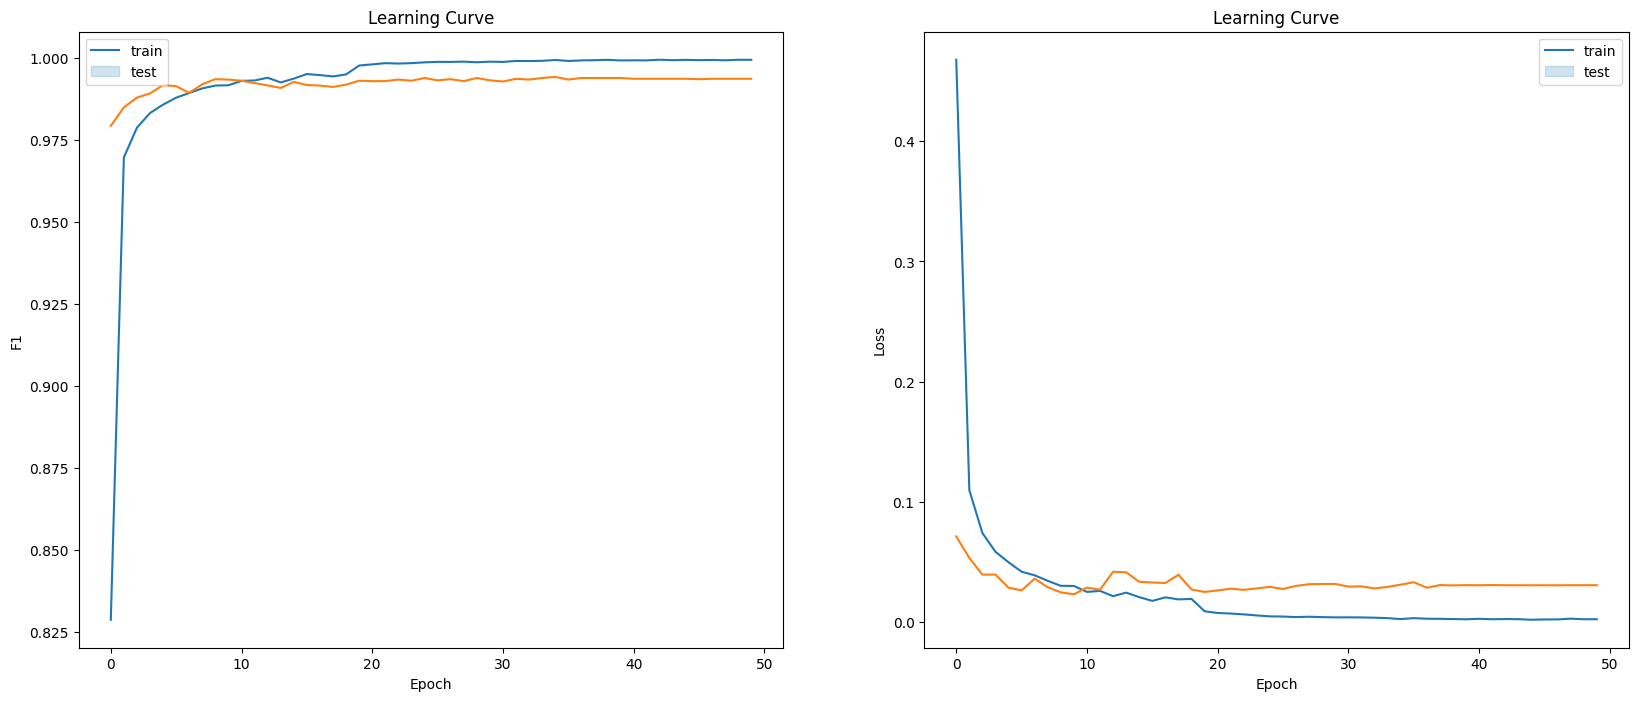

In [32]:
draw_learning_curve(learning_history)

In [33]:
y_pred = model.predict(X_val)

132/132 [==============================] - 1s 3ms/step


In [34]:
def draw_output(idx_nums):
    plt.figure(figsize = (20, 20))
    plt.xticks( range(10) )
    x = int(np.ceil(np.sqrt(len(idx_nums))))
    cnt = 1
    for ph in idx_nums:
        plt.subplot(x, x, cnt)
        curr_photo = y_val[ph]

        plt.xlim(0, 10)
        plt.title("Digit: {0}\n idx: {1} ".format(np.argmax(y_val[ph]), ph), fontsize = 10)
        plt.bar(range(10), y_pred[ph])

        cnt += 1

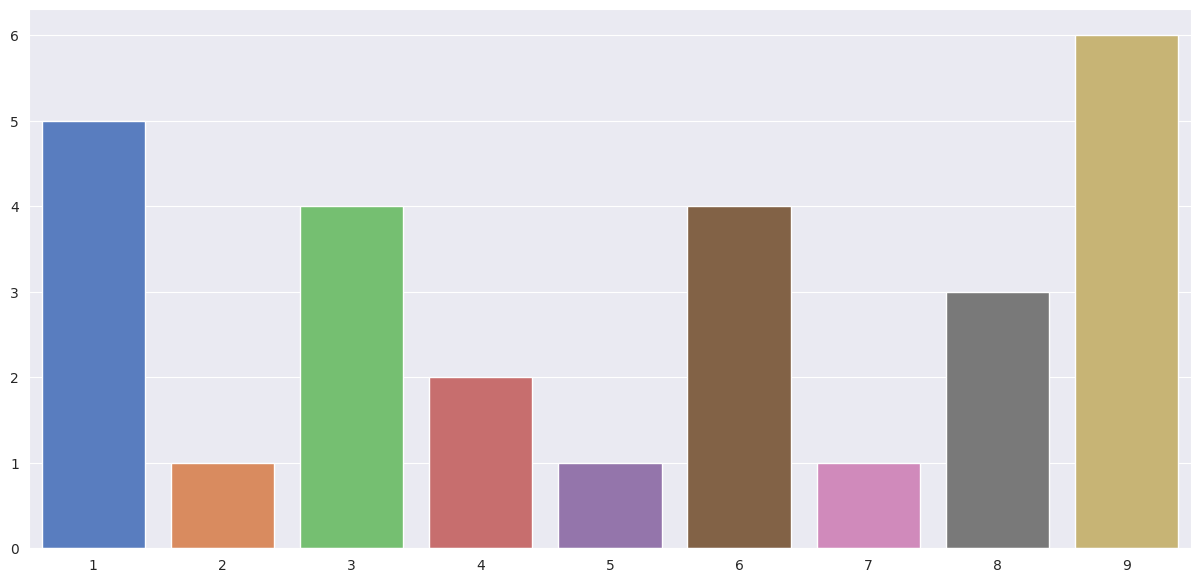

In [35]:


cnt_error = []
for idx, (a, b) in enumerate(zip(y_val, y_pred)):
    if np.argmax(a) == np.argmax(b):
        continue
    cnt_error.append(np.argmax(a))

cnt_error = np.unique(cnt_error, return_counts=True)
sns.set_style("darkgrid")
plt.figure(figsize=(15, 7))
bar_plot = sns.barplot(x=cnt_error[0], y=cnt_error[1], palette="muted")
plt.show()


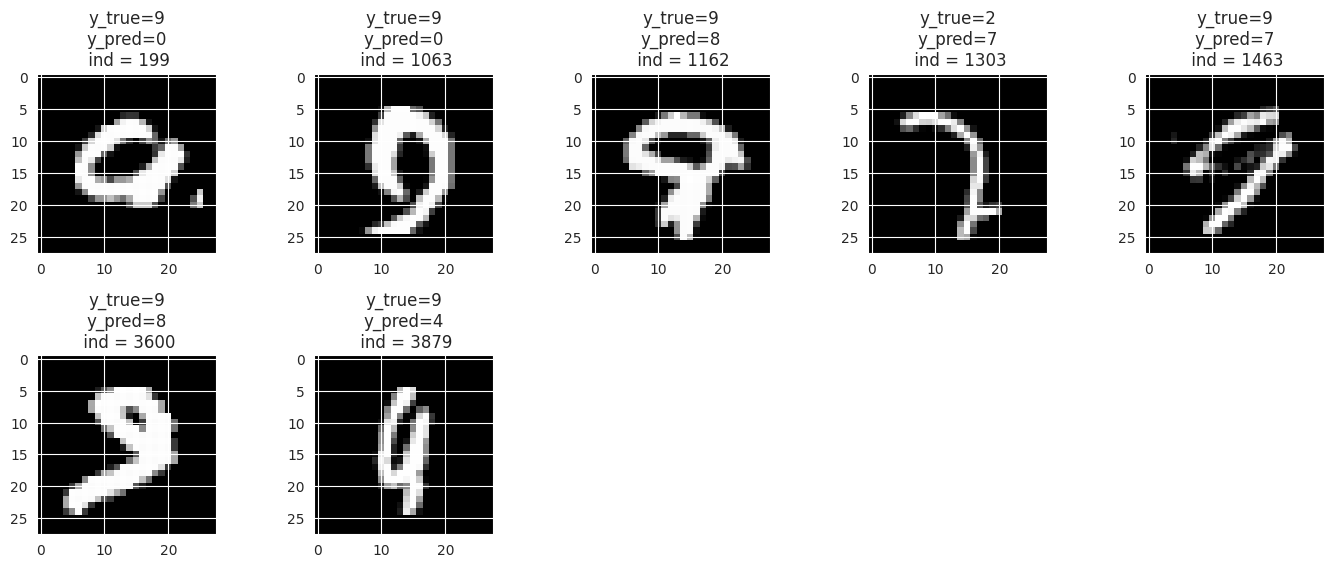

In [36]:
cnt_ind = 1
list_idx = []
X_val_plot = X_val.reshape( X_val.shape[:-1] )
fig = plt.figure(figsize=(14, 14))

for idx, (a, b) in enumerate(zip(y_val, y_pred)):
    if np.argmax(a) == np.argmax(b): continue
    if (np.argmax(a) == 2 or np.argmax(a) == 9):
        plt.subplot(5, 5, cnt_ind)
        plt.imshow(X_val_plot[idx], cmap='gray', interpolation='none')
        plt.title('y_true={0}\ny_pred={1}\n ind = {2}'.format(np.argmax(a), np.argmax(b), idx))
        plt.tight_layout()
        list_idx.append(idx)
        cnt_ind += 1

<ipython-input-34-f85cef2ca351>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(x, x, cnt)


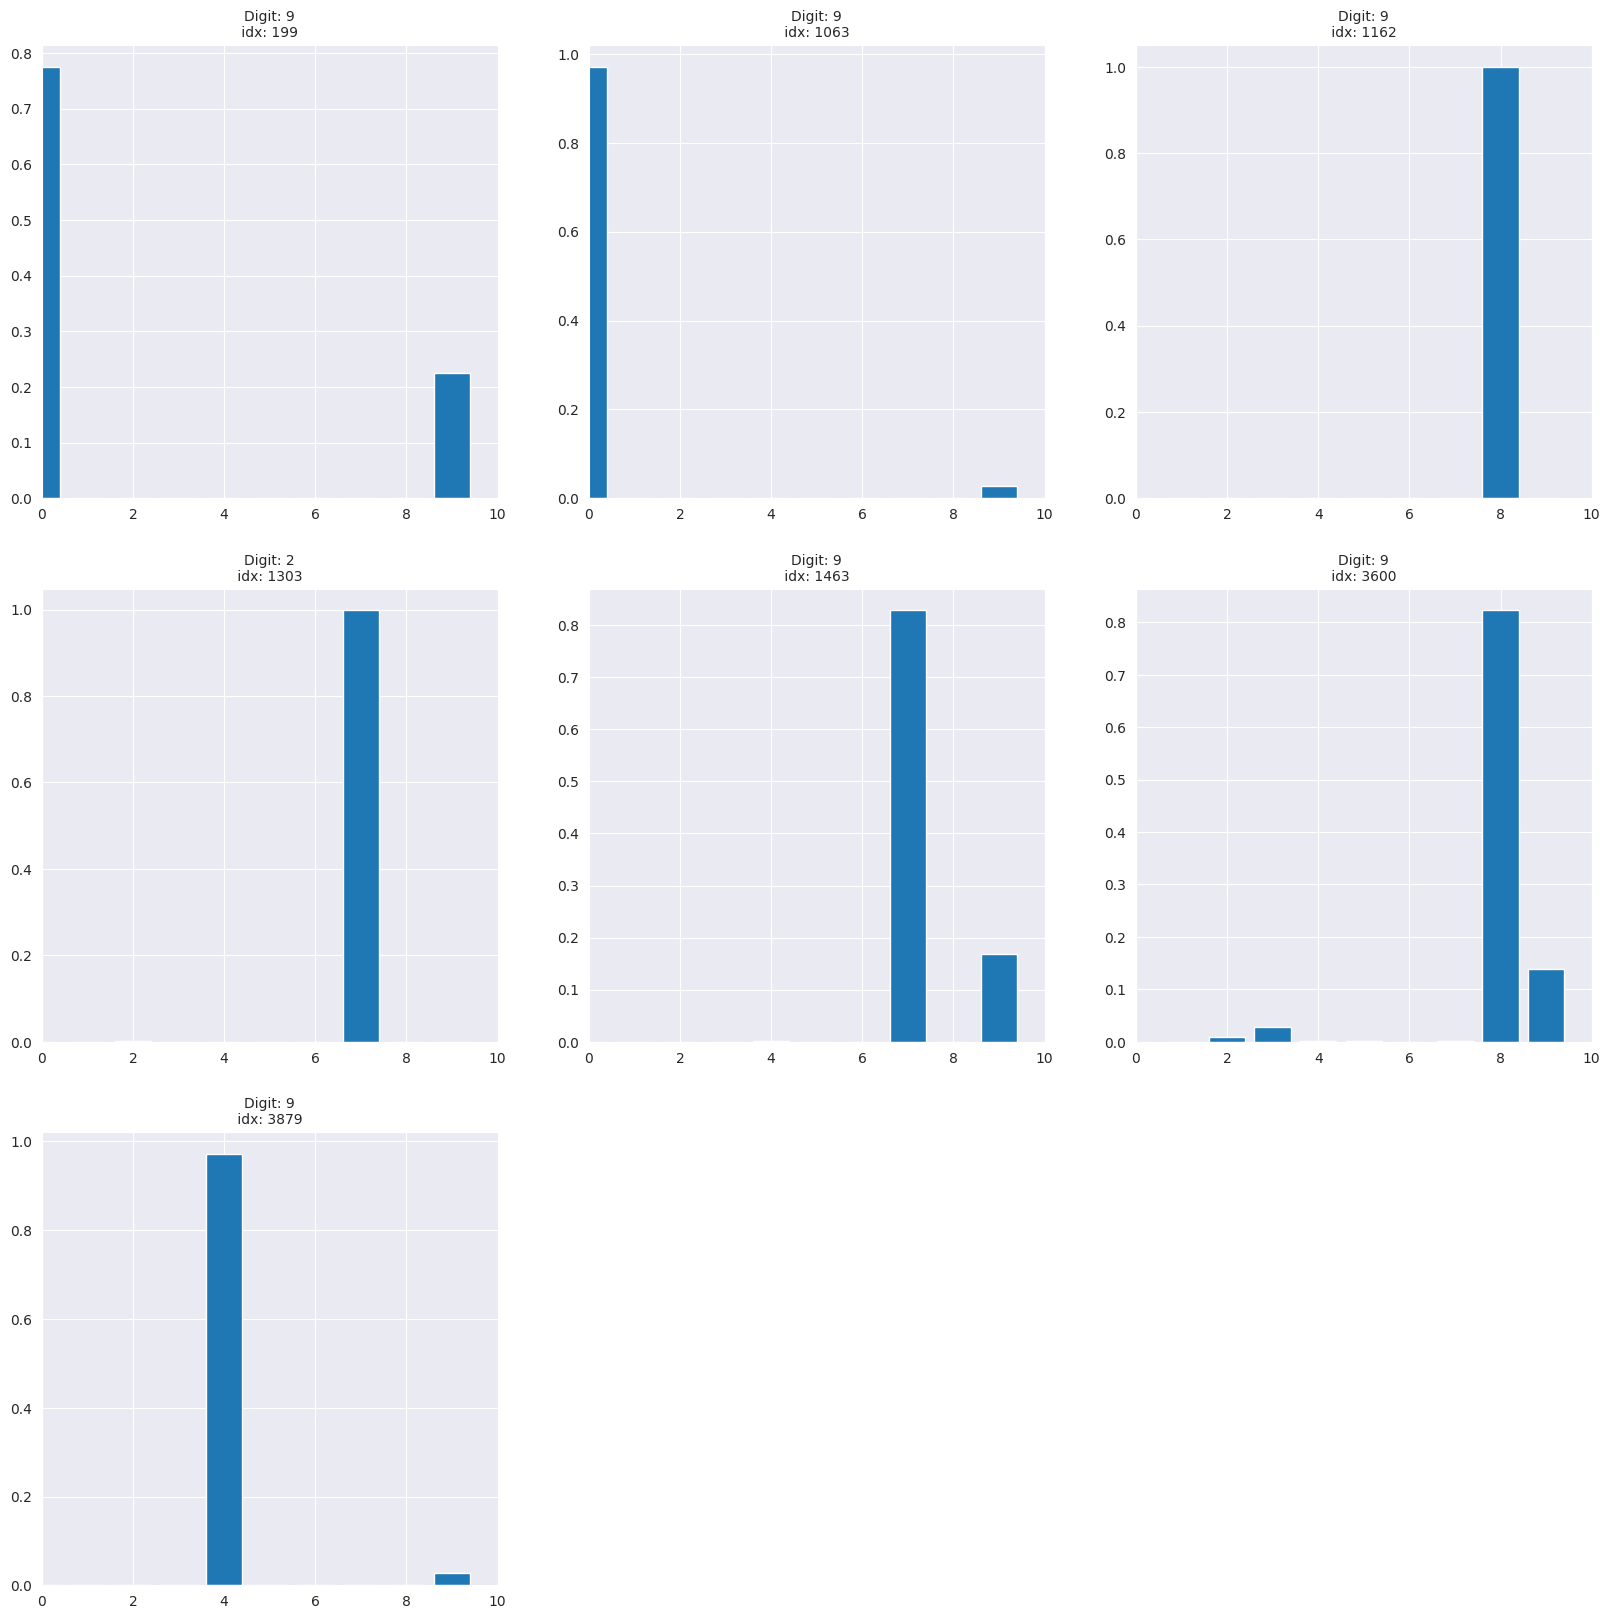

In [37]:
draw_output(list_idx)

In [38]:
train_aug = ImageDataGenerator(
        featurewise_center = False,
        samplewise_center = False,
        featurewise_std_normalization = False,
        samplewise_std_normalization = False,
        zca_whitening = False,
        horizontal_flip = False,
        vertical_flip = False,
        fill_mode = 'nearest',
        rotation_range = 10,
        zoom_range = 0.1,
        width_shift_range = 0.1,
        height_shift_range = 0.1)


train_aug.fit(X_train)
train_gen = train_aug.flow(X_train, y_train, batch_size=64)

In [39]:
def get_cnn_v2():
    return Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape),
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same' ),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same' ),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same' ),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),


        Flatten(),

        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(num_classes, activation = "softmax")

    ])

In [40]:
model = get_cnn_v2()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=[f1])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 64)       

In [41]:
learning_history = model.fit_generator(train_gen, epochs = 100,
                               steps_per_epoch = X_train.shape[0] // 64,
                               validation_data = (X_val, y_val),
                               callbacks = callbacks('best_cnn'),
                             )


Epoch 1/100


<ipython-input-41-04d000c25a12>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  learning_history = model.fit_generator(train_gen, epochs = 100,


590/590 [==============================] - 28s 35ms/step - loss: 0.6722 - f1: 0.7704 - val_loss: 0.2447 - val_f1: 0.9239 - lr: 0.0010
Epoch 2/100
590/590 [==============================] - 22s 37ms/step - loss: 0.1764 - f1: 0.9482 - val_loss: 0.0581 - val_f1: 0.9838 - lr: 0.0010
Epoch 3/100
590/590 [==============================] - 20s 34ms/step - loss: 0.1290 - f1: 0.9634 - val_loss: 0.0609 - val_f1: 0.9809 - lr: 0.0010
Epoch 4/100
590/590 [==============================] - 21s 36ms/step - loss: 0.0995 - f1: 0.9727 - val_loss: 0.0443 - val_f1: 0.9868 - lr: 0.0010
Epoch 5/100
590/590 [==============================] - 21s 35ms/step - loss: 0.0923 - f1: 0.9739 - val_loss: 0.0292 - val_f1: 0.9912 - lr: 0.0010
Epoch 6/100
590/590 [==============================] - 20s 34ms/step - loss: 0.0853 - f1: 0.9763 - val_loss: 0.0367 - val_f1: 0.9912 - lr: 0.0010
Epoch 7/100
590/590 [==============================] - 20s 34ms/step - loss: 0.0744 - f1: 0.9786 - val_loss: 0.0363 - val_f1: 0.9897 - l

In [43]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test score:', score[1])

print("CNN Error: %.2f%%" % (100-score[1]*100))

Test loss: 0.012499635107815266
Test score: 0.9964488744735718
CNN Error: 0.36%


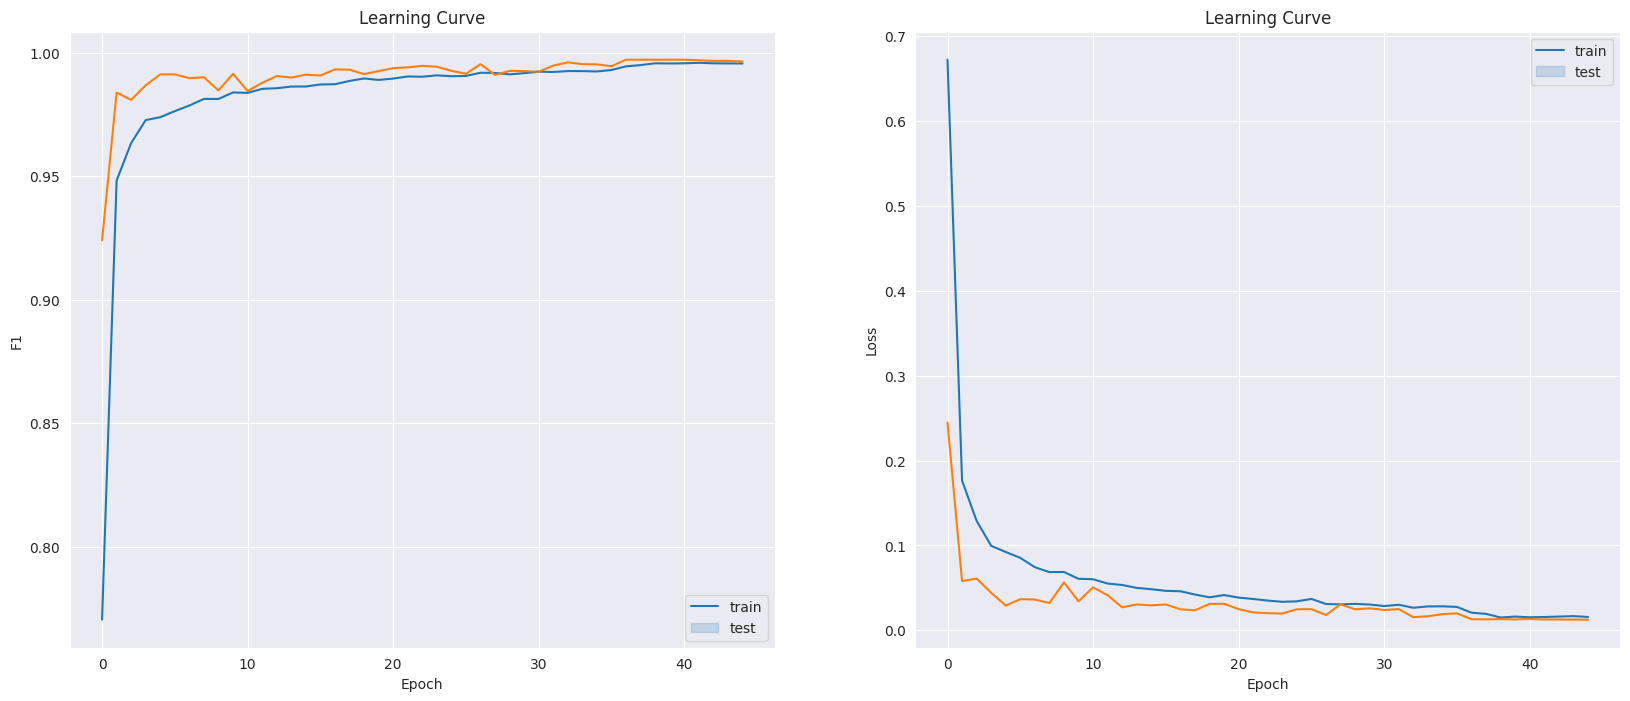

In [44]:
draw_learning_curve(learning_history)


In [45]:
output = model.predict(X_test)

output = np.argmax(output, axis = 1)

output = pd.Series(output, name="Label")

submission = pd.concat([pd.Series(range(1,28001), name = "ImageId"), output], axis = 1)

submission.to_csv("submission.csv", index=False)

875/875 [==============================] - 3s 4ms/step


In [47]:
def load_data(path):
    with np.load(path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']
        return (x_train, y_train), (x_test, y_test)

(x_train1, y_train1), (x_test1, y_test1) = load_data('/content/drive/MyDrive/mnist.npz')

In [48]:
x_train1 = x_train1 / 255
x_test1 = x_test1 / 255

x_train1 = x_train1.reshape(-1, 28, 28, 1)
x_test1 = x_test1.reshape(-1, 28, 28, 1)

y_train1 = y_train1.reshape(y_train1.shape[0], 1)
y_test1 = y_test1.reshape(y_test1.shape[0], 1)

In [49]:
Add_X = np.vstack((x_train1, x_test1))

Add_y = np.vstack((y_train1, y_test1))

Add_y = to_categorical(Add_y)

In [50]:
train = pd.read_csv("/content/drive/MyDrive/train.csv")

X_train = train.drop(labels = ["label"], axis = 1)
y_train = train['label']
y_train = to_categorical(y_train)

X_train /= 255
X_train = X_train.values.reshape(-1, 28, 28, 1)

In [52]:
add_train_aug = ImageDataGenerator(
        featurewise_center = False,
        samplewise_center = False,
        featurewise_std_normalization = False,
        samplewise_std_normalization = False,
        zca_whitening = False,
        horizontal_flip = False,
        vertical_flip = False,
        fill_mode = 'nearest',
        rotation_range = 10,
        zoom_range = 0.1,
        width_shift_range = 0.1,
        height_shift_range = 0.1)


add_train_aug.fit(Add_X)
add_train_gen = add_train_aug.flow(Add_X, Add_y, batch_size=64)

In [53]:
model = get_cnn_v2()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=[f1])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_6 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 14, 14, 64)       

In [54]:
learning_history = model.fit_generator((add_train_gen), epochs = 100,
                               steps_per_epoch = x_train1.shape[0] // 64,
                               validation_data = (X_val, y_val),
                               callbacks = callbacks('cnn_bonus'),
                             )

Epoch 1/100


<ipython-input-54-85392b538084>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  learning_history = model.fit_generator((add_train_gen), epochs = 100,


937/937 [==============================] - 39s 35ms/step - loss: 0.5026 - f1: 0.8325 - val_loss: 0.1428 - val_f1: 0.9534 - lr: 0.0010
Epoch 2/100
937/937 [==============================] - 31s 34ms/step - loss: 0.1352 - f1: 0.9619 - val_loss: 0.0404 - val_f1: 0.9883 - lr: 0.0010
Epoch 3/100
937/937 [==============================] - 33s 35ms/step - loss: 0.0968 - f1: 0.9724 - val_loss: 0.0578 - val_f1: 0.9846 - lr: 0.0010
Epoch 4/100
937/937 [==============================] - 31s 33ms/step - loss: 0.0826 - f1: 0.9770 - val_loss: 0.0216 - val_f1: 0.9924 - lr: 0.0010
Epoch 5/100
937/937 [==============================] - 32s 34ms/step - loss: 0.0710 - f1: 0.9798 - val_loss: 0.0379 - val_f1: 0.9883 - lr: 0.0010
Epoch 6/100
937/937 [==============================] - 31s 33ms/step - loss: 0.0682 - f1: 0.9818 - val_loss: 0.0290 - val_f1: 0.9900 - lr: 0.0010
Epoch 7/100
937/937 [==============================] - 30s 32ms/step - loss: 0.0598 - f1: 0.9840 - val_loss: 0.0255 - val_f1: 0.9927 - l

In [58]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test score:', score[1])

print("CNN Error: %.2f%%" % (100-score[1]*100))

Test loss: 0.0014114083023741841
Test score: 0.9995265007019043
CNN Error: 0.05%


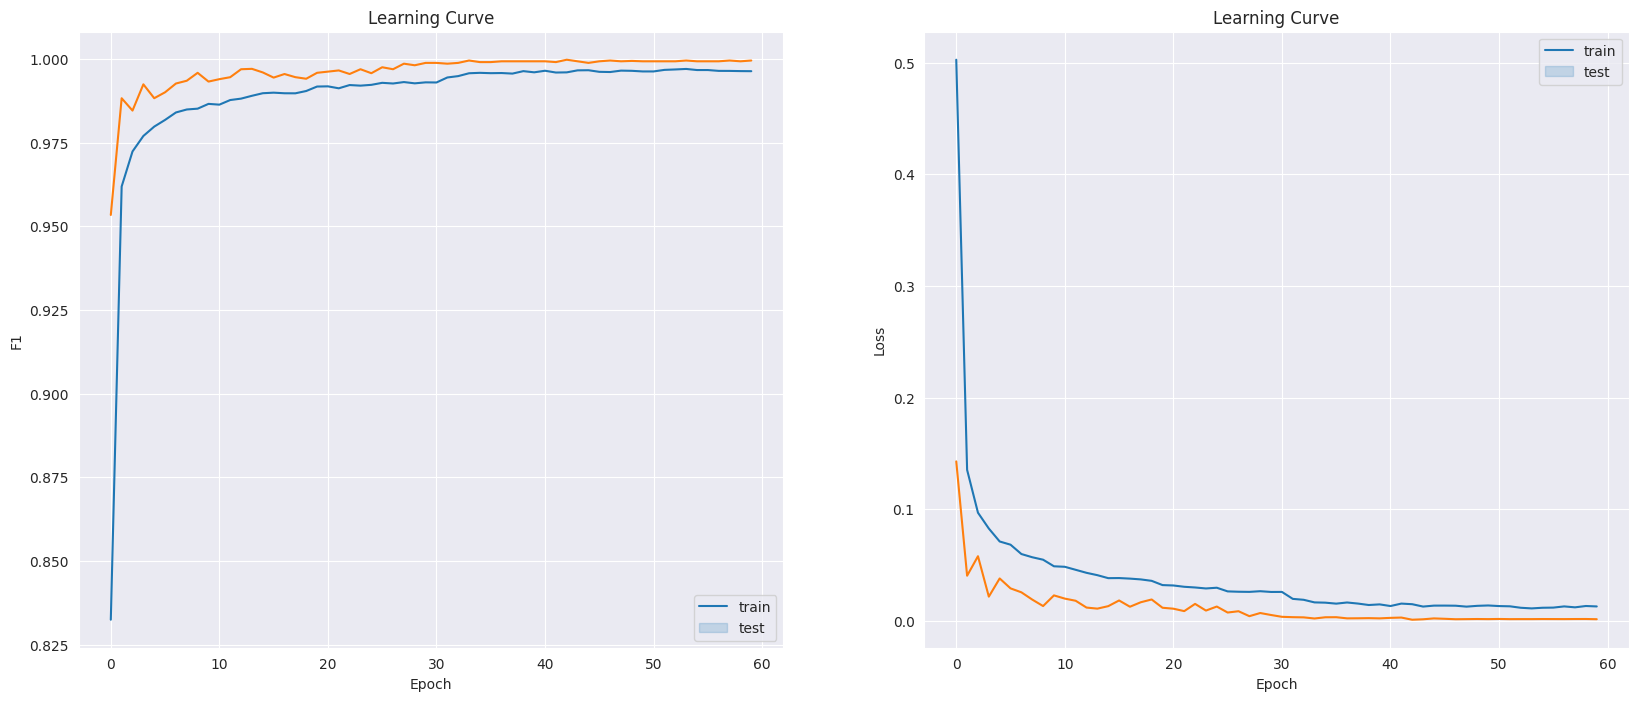

In [59]:
draw_learning_curve(learning_history)

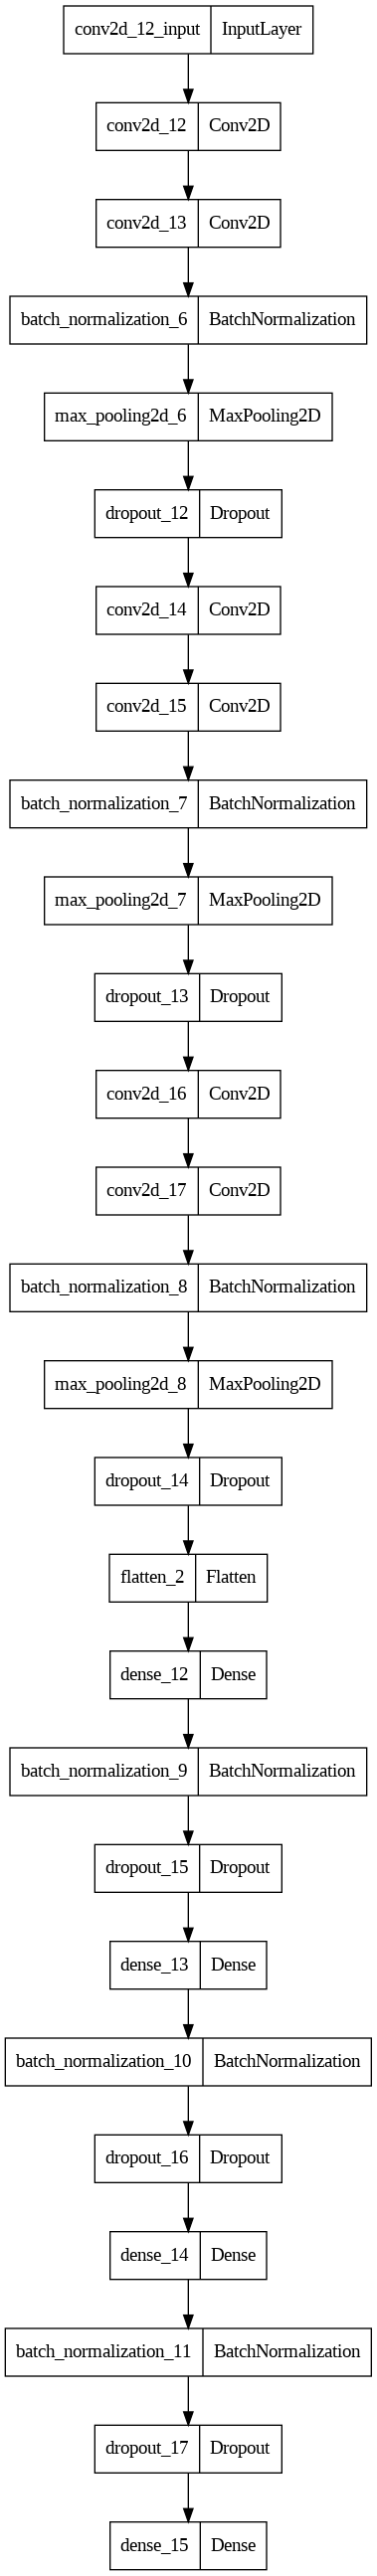

In [60]:
plot_model(model)

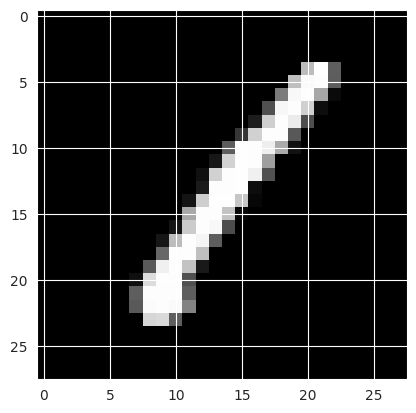

In [61]:
plt.imshow(X_train[0].reshape(28, 28), cmap='gray');

In [62]:
def apply_grey_patch(image, top_left_x, top_left_y, patch_size):
    patched_image = np.array(image, copy=True)
    patched_image[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size, :] = 0

    return patched_image


img = X_train[0]

PATCH_SIZE = 4
sensitivity_map = np.zeros((img.shape[0], img.shape[0]))

for top_left_x in range(0, img.shape[0], PATCH_SIZE):
    for top_left_y in range(0, img.shape[1], PATCH_SIZE):
        patched_image = apply_grey_patch(img, top_left_x, top_left_y, PATCH_SIZE)


        predicted_classes = model.predict(np.array([patched_image]))[0]
        confidence = predicted_classes[1]

        sensitivity_map[
            top_left_y:top_left_y + PATCH_SIZE,
            top_left_x:top_left_x + PATCH_SIZE,
        ] = confidence


1/1 [==============================] - 0s 18ms/step


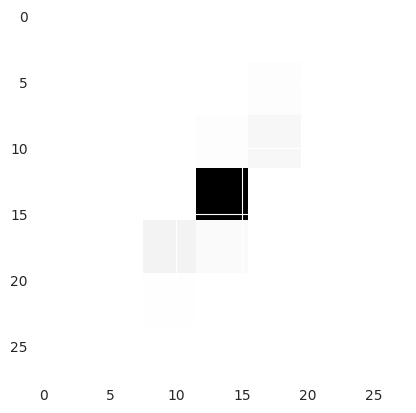

In [63]:
plt.imshow(sensitivity_map, cmap='gray');

In [64]:
output = model.predict(X_test)

output = np.argmax(output, axis = 1)

output = pd.Series(output, name="Label")

submission = pd.concat([pd.Series(range(1,28001), name = "ImageId"), output], axis = 1)

submission.to_csv("bonus_submission.csv", index=False)

875/875 [==============================] - 2s 3ms/step
